# Importing the required modules

In [1]:
# Modules used for data handling and manipulation
import numpy as np
import pandas as pd
import json

# Modules used for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Modules used for clustering time series
import tslearn as ts
from tslearn.clustering import TimeSeriesKMeans, KShape
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer

# Modules used for preprocessing
from datetime import datetime
import preprocess

# Module for suppressing warnings.
import warnings 
warnings.filterwarnings('ignore')

# Data preprocessing

In [2]:
a = preprocess.preprocess_modelling(as_numpy=True, clustered = False)
electricity = preprocess.preprocess_modelling(as_numpy=False, clustered = False)

# Data Standardization

In [3]:
a = TimeSeriesScalerMeanVariance().fit_transform(a)

# K-Means Clustering

606.824 --> 454.592 --> 454.529 --> 454.529 --> 
580.757 --> 428.278 --> 423.601 --> 421.009 --> 419.424 --> 417.788 --> 415.916 --> 415.628 --> 415.628 --> 
560.742 --> 408.219 --> 405.547 --> 402.537 --> 399.073 --> 397.474 --> 395.164 --> 392.938 --> 390.727 --> 390.200 --> 390.088 --> 389.967 --> 389.912 --> 389.859 --> 389.821 --> 389.821 --> 
551.591 --> 397.048 --> 392.310 --> 389.474 --> 386.295 --> 384.449 --> 382.528 --> 380.668 --> 378.776 --> 376.920 --> 376.811 --> 376.811 --> 
544.158 --> 384.093 --> 378.647 --> 374.459 --> 372.700 --> 370.322 --> 369.511 --> 369.250 --> 369.119 --> 368.993 --> 368.927 --> 368.868 --> 368.801 --> 368.768 --> 368.768 --> 
519.626 --> 376.126 --> 369.689 --> 366.942 --> 364.128 --> 362.778 --> 359.118 --> 353.287 --> 350.406 --> 350.100 --> 350.100 --> 


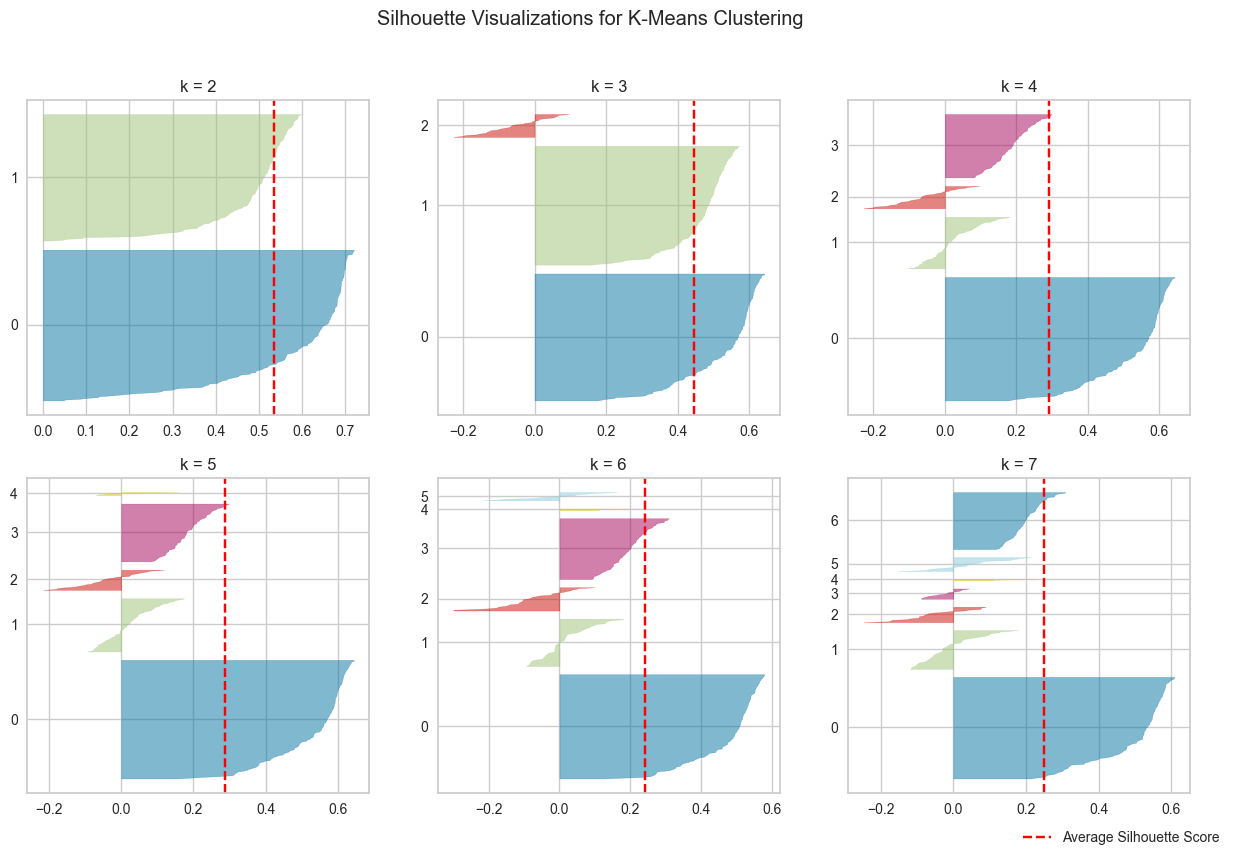

In [4]:
score = []
fig, ax = plt.subplots(2, 3, figsize=(15,9))

for k in range(2, 8):
    km = TimeSeriesKMeans(n_clusters = k, verbose = True, random_state = 42)
    y_pred = km.fit_predict(a)

    #init.append(km.inertia_)
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[(k - 2)//3][(k - 2)%3])
    visualizer.fit(a.reshape(333, 1462))
    ax[(k - 2)//3][(k - 2)%3].set_title(f"k = {k}")
    ax[(k - 2)//3][(k - 2)%3].set_yticks(ticks = visualizer.y_tick_pos_,
                                         labels = list(range(0, k)))
plt.suptitle("Silhouette Visualizations for K-Means Clustering")
plt.subplots_adjust(hspace=0.2)
plt.legend(loc='upper center', bbox_to_anchor=(0.8, -0.08))
plt.yticks()
plt.show()

- It is evident that k = 2 is the best value for hyperparameter k for K-means clustering. This is because:

1. The average silhouette score is the highest and relatively closest to 1.
2. There are no negative values for silhouette score indicating that each time series was allotted a well-matched cluster.
3. The shape of the plots for each cluster is pretty consistent.

- As, the value of k increases, there are inconsistencies in shapes of the plots for each cluster. 

- Moreover, negative values exist for each of the clusters and the average score is closer to 0.

- This implies that these are not clustering the time series data well.

# Clusters for k = 2

606.824 --> 454.592 --> 454.529 --> 454.529 --> 


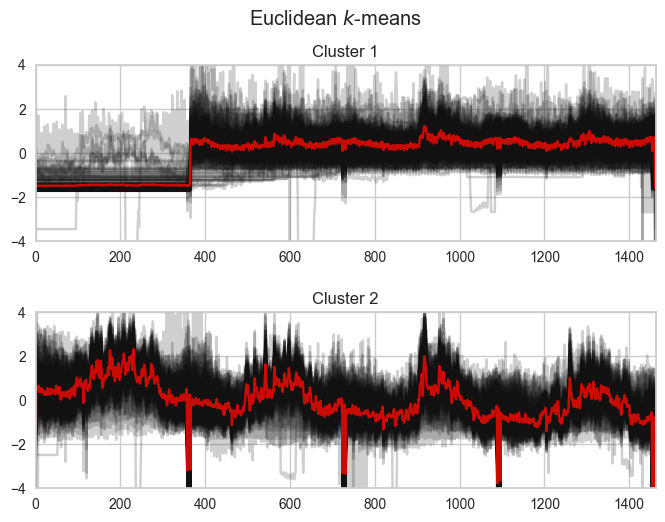

In [4]:
km = TimeSeriesKMeans(n_clusters = 2, verbose = True, random_state = 42)
y_pred = km.fit_predict(a)

fig, axs = plt.subplots(2)
for yi in range(2):
    c = 0
    for xx in a[y_pred == yi]:
        axs[yi].plot(xx.ravel(), "k-", alpha=.2)
    axs[yi].plot(km.cluster_centers_[yi].ravel(), "r-")
    axs[yi].set_xlim(0, a.shape[1])
    axs[yi].set_ylim(-4, 4)
    axs[yi].set_title(f"Cluster {yi + 1}")
plt.subplots_adjust(hspace=0.4)
plt.suptitle("Euclidean $k$-means")
plt.show()

- However, by the nature of this dataset, there are zeroes in the data until the electricity services begins at the customer. 

- Visually, these zero give a plateau-like shape which biases the clustering algorithm. 

- Therefore, the above clustering has put all customers added in 2012 to cluster 1 and those added in 2011 to cluster 1 which inappropriate.

- To resolve this, we re-cluster the cluster 1 by only considering the time series from 2012.

# Storing the clusters

In [5]:
def get_cluster_with_clients(y_pred, cols):    
    temp = list(zip(y_pred, cols))
    clusters = dict()

    for i in temp:
        cluster_id, cust = i
        if cluster_id not in clusters:
            clusters[int(cluster_id)] = [cust]
        else:
            clusters[int(cluster_id)].append(cust)
    return clusters

In [6]:
cols = [i for i in electricity.columns if i != "date"]
main_clusters = get_cluster_with_clients(y_pred, cols)

In [7]:
a = electricity[main_clusters[0]][366:].values.T
a = np.expand_dims(a, axis = -1)
a = TimeSeriesScalerMeanVariance().fit_transform(a)

In [8]:
a.shape

(181, 1096, 1)

1012.079 --> 619.975 --> 612.845 --> 606.939 --> 605.254 --> 604.936 --> 603.651 --> 602.560 --> 602.250 --> 602.250 --> 
877.091 --> 541.469 --> 533.667 --> 531.981 --> 530.383 --> 530.383 --> 
887.050 --> 542.256 --> 513.467 --> 496.359 --> 492.316 --> 491.492 --> 491.492 --> 
768.812 --> 491.929 --> 486.363 --> 485.220 --> 483.177 --> 481.726 --> 480.994 --> 480.994 --> 
767.754 --> 479.267 --> 472.670 --> 472.670 --> 


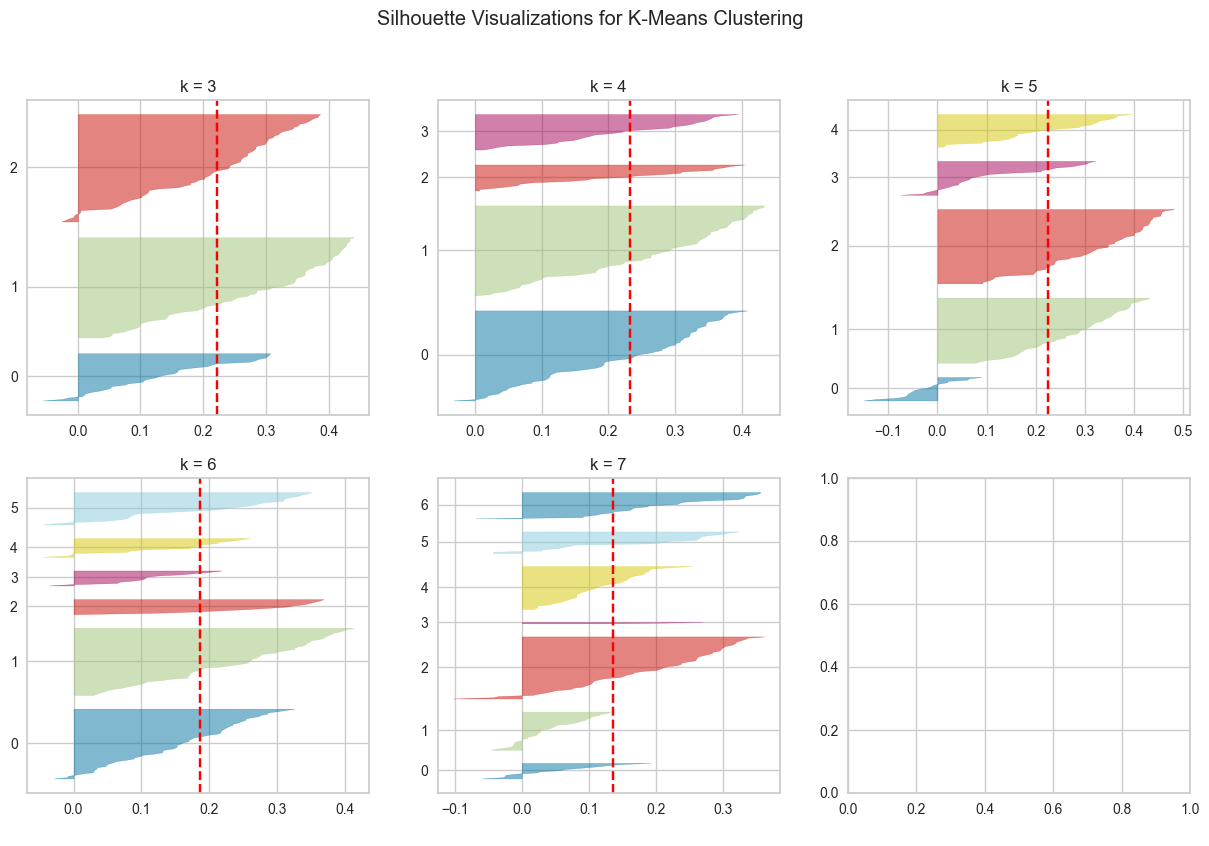

In [72]:
fig, ax = plt.subplots(2, 3, figsize=(15,9))

for k in range(2, 7):
    t = k + 1
    km = TimeSeriesKMeans(n_clusters = t, verbose = True)
    y_pred = km.fit_predict(a)

    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[(k - 2)//3][(k - 2)%3])
    visualizer.fit(a.reshape(len(clusters[0]), a.shape[1]))
    ax[(k - 2)//3][(k - 2)%3].set_title(f"k = {t}")
    ax[(k - 2)//3][(k - 2)%3].set_yticks(ticks = visualizer.y_tick_pos_,
                                         labels = list(range(0, t)))
plt.suptitle("Silhouette Visualizations for K-Means Clustering")
plt.subplots_adjust(hspace=0.2)
plt.legend(loc='upper center', bbox_to_anchor=(0.8, -0.08))
plt.yticks()
plt.show()

- Based on the above plot, it seems like k = 4 is best value since it has the highest average silhoutte score.

1093.965 --> 559.786 --> 534.947 --> 532.570 --> 531.179 --> 530.164 --> 529.765 --> 529.765 --> 


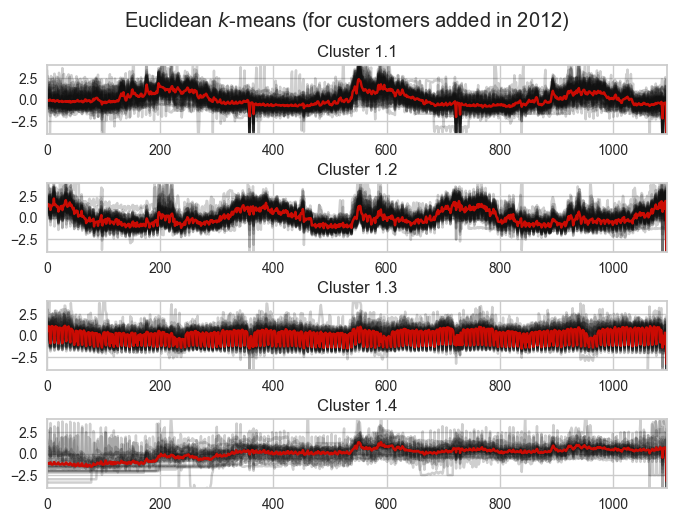

In [9]:
km = TimeSeriesKMeans(n_clusters = 4, verbose = True, random_state = 42)
y_pred = km.fit_predict(a)

fig, axs = plt.subplots(4)
for yi in range(4):
    c = 0
    for xx in a[y_pred == yi]:
        axs[yi].plot(xx.ravel(), "k-", alpha=.2)
    axs[yi].plot(km.cluster_centers_[yi].ravel(), "r-")
    axs[yi].set_xlim(0, a.shape[1])
    axs[yi].set_ylim(-4, 4)
    axs[yi].set_title(f"Cluster 1.{yi + 1}")
plt.subplots_adjust(hspace=0.7)
plt.suptitle("Euclidean $k$-means (for customers added in 2012)")
plt.show()

<b><u>Note</u></b>: These time-series <b>start from 2012 and not 2011</b>!

In [10]:
sub_clusters = get_cluster_with_clients(y_pred + 1, main_clusters[0])

In [11]:
_ = main_clusters.pop(0)
main_clusters[0] = main_clusters.pop(1)

In [12]:
main_clusters.keys()

dict_keys([0])

In [13]:
all_clusters = main_clusters | sub_clusters

# Saving the clusters in JSON file

In [142]:
with open("clusters.json", "w") as f:
    json.dump(all_clusters, f, indent = 4)

In [14]:
with open("clusters.json", "r") as f:
        clusters = json.load(fp = f)
        for cluster in clusters:
            electricity["cluster_" + str(cluster)] = electricity[clusters[cluster]].sum(axis = 1)
        electricity = electricity.drop([i for i in electricity.columns if "cluster" not in i], 
                                       axis = 1)